<a href="https://colab.research.google.com/github/viviannemedeiros/modelosDescritivos/blob/master/ModelosDescritivos_Absenteeism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Projeto Final - Modelos Descritivos - 10/07/2020** 

**Prof:** Paulo Salgado

**Discente:** Vivianne Medeiros


In [92]:
# Importando libs necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_validate

In [93]:
dados = pd.read_csv('https://raw.githubusercontent.com/viviannemedeiros/modelosDescritivos/master/datasets-455676-859489-Absenteeism_at_work.csv', 
                    sep=';', index_col="ID")

### **Análise Exploratória dos Dados**

In [94]:
dados.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
ID,,,,,,,,,,,,,,,,,,,,
11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [95]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740 entries, 11 to 35
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reason for absence               740 non-null    int64  
 1   Month of absence                 740 non-null    int64  
 2   Day of the week                  740 non-null    int64  
 3   Seasons                          740 non-null    int64  
 4   Transportation expense           740 non-null    int64  
 5   Distance from Residence to Work  740 non-null    int64  
 6   Service time                     740 non-null    int64  
 7   Age                              740 non-null    int64  
 8   Work load Average/day            740 non-null    float64
 9   Hit target                       740 non-null    int64  
 10  Disciplinary failure             740 non-null    int64  
 11  Education                        740 non-null    int64  
 12  Son                   

In [96]:
dados.describe()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,6.924324
std,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,13.330998
min,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,120.000000


In [97]:
# Verificando quantidade de dados nulos
dados.isnull().sum()

Reason for absence                 0
Month of absence                   0
Day of the week                    0
Seasons                            0
Transportation expense             0
Distance from Residence to Work    0
Service time                       0
Age                                0
Work load Average/day              0
Hit target                         0
Disciplinary failure               0
Education                          0
Son                                0
Social drinker                     0
Social smoker                      0
Pet                                0
Weight                             0
Height                             0
Body mass index                    0
Absenteeism time in hours          0
dtype: int64

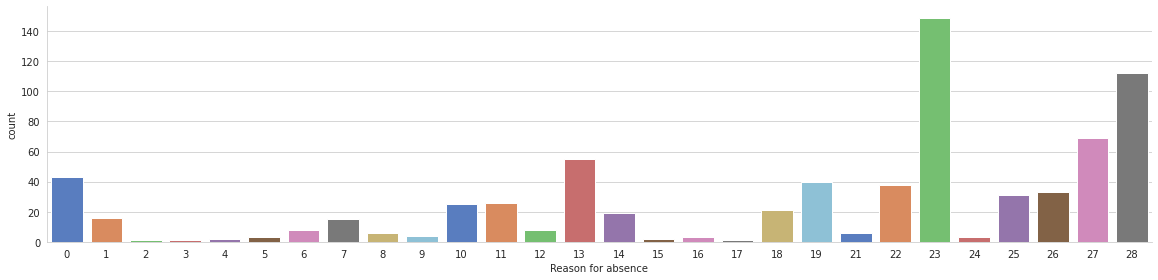

In [98]:
sns.set_style("whitegrid")
sns.catplot(data=dados, x='Reason for absence', kind= 'count',height=4, aspect=4, palette='muted')

In [99]:
categoricos = ['Reason for absence','Month of absence','Day of the week',
                     'Seasons','Disciplinary failure', 'Education', 'Social drinker',
                     'Social smoker']
numericos = dados.drop(columns=categoricos).columns.to_list()

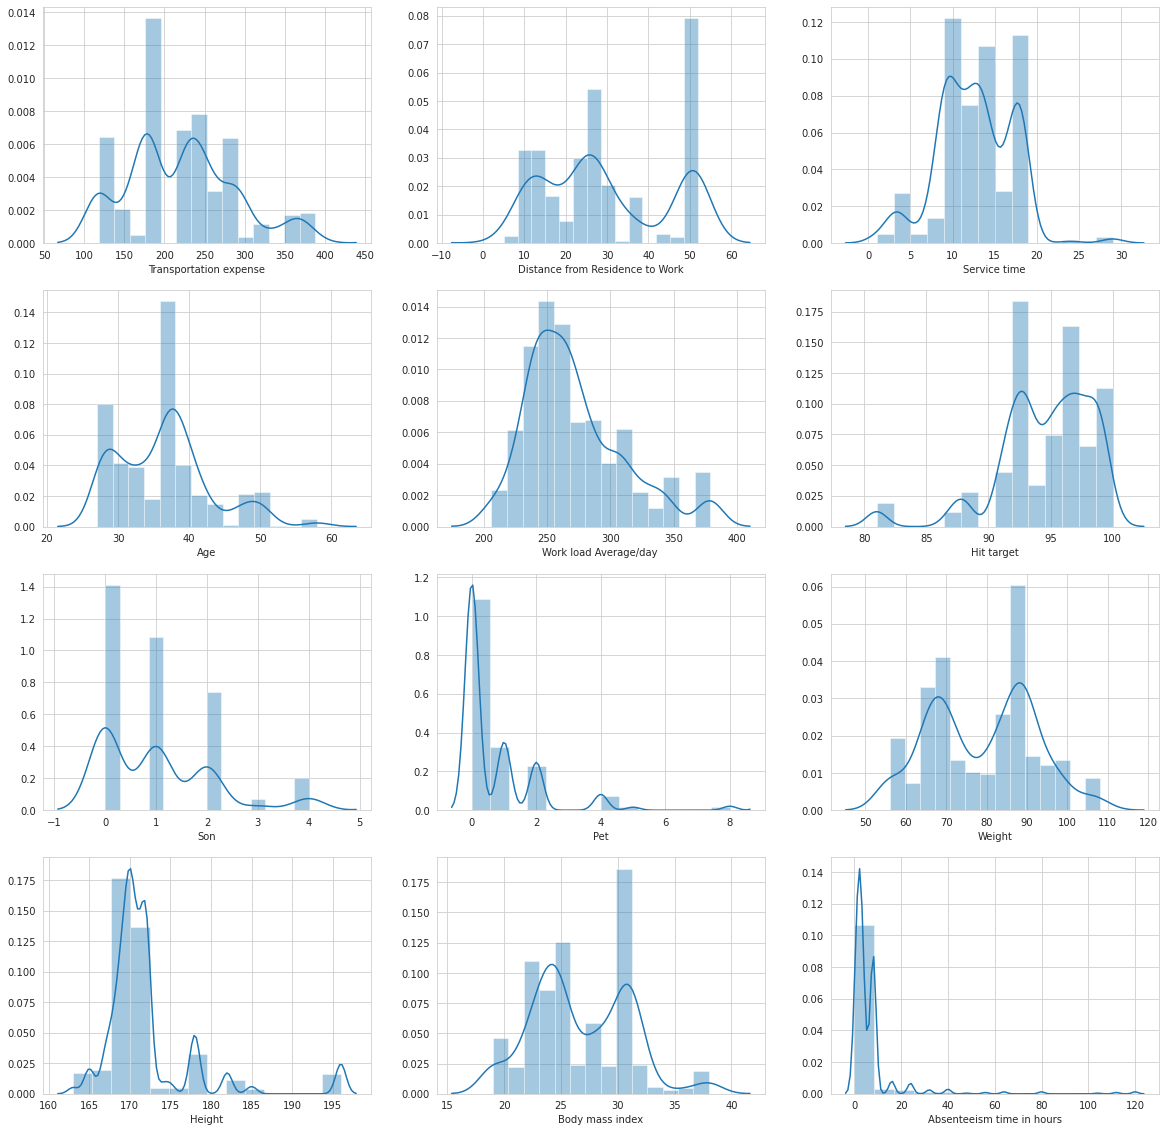

In [100]:
num_df = dados[numericos]
plt.figure(figsize=(20,20))
for i in range(1, 13):
    plt.subplot(4, 3, i)
    sns.distplot(num_df[num_df.columns[i-1]],bins=14)

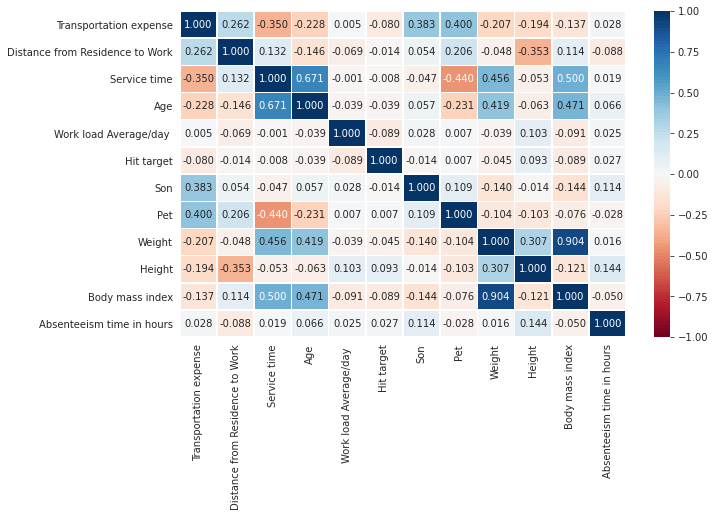

In [101]:
num_corr = num_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(num_corr, annot=True, fmt=".3f",vmin=-1, vmax=1, linewidths=.5, cmap = sns.color_palette("RdBu", 100))
plt.yticks(rotation=0)
plt.show()

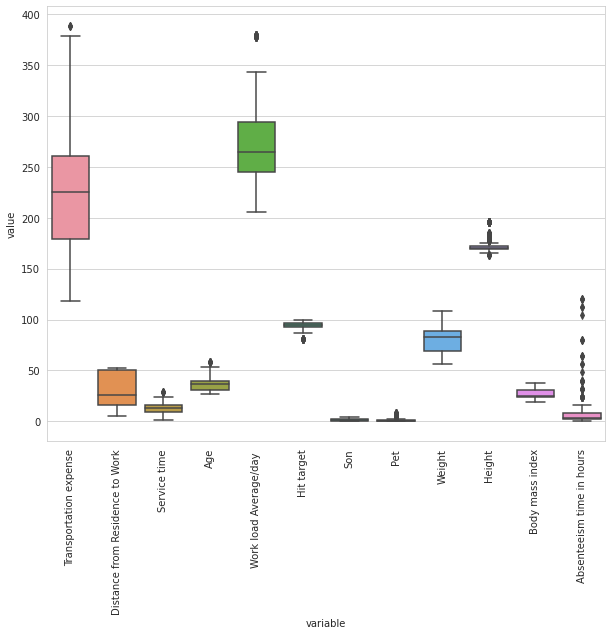

In [102]:
plt.figure(figsize=(10,8))
sns.boxplot(x="variable", y="value", data=pd.melt(num_df))
plt.xticks(rotation=90)
plt.show()

### **Pré-processamento**

In [103]:
dados['Disciplinary failure'].unique()

array([0, 1])

In [104]:
dados['Social drinker'].unique()

array([1, 0])

In [105]:
dados['Social smoker'].unique()

array([0, 1])

In [106]:
# Transforma os atributos categóricos para não influenciar no cálculo da distância
Reason = pd.get_dummies(dados['Reason for absence'], drop_first=True)
Month = pd.get_dummies(dados['Month of absence'], drop_first=True)
DayOfWeek = pd.get_dummies(dados['Day of the week'], drop_first=True)
Seasons = pd.get_dummies(dados['Seasons'], drop_first=True)
Education = pd.get_dummies(dados['Education'], drop_first=True)

dados.drop(['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Education'], axis=1,inplace=True)
dados = pd.concat([dados, Reason, Month, DayOfWeek, Seasons, Education],axis=1)

In [107]:
dados.sample(5)

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21,22,23,24,25,26,27,28,1,2,3,4,5,6,7,8,9,10,11,12,3,4,5,6,2,3,4,2,3,4
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24,246,25,16,41,294.217,81,0,0,1,0,0,67,170,23,16,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
11,289,36,13,33,308.593,95,0,2,1,0,1,90,172,30,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,179,51,18,38,265.017,88,0,0,1,0,0,89,170,31,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
5,235,20,13,43,241.476,92,0,1,1,0,0,106,167,38,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
34,118,10,10,37,284.031,97,0,0,0,0,0,83,172,28,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [108]:
from sklearn.preprocessing import MinMaxScaler

In [109]:
scaler = MinMaxScaler()

In [110]:
scaler.fit(dados)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [111]:
dados_normalizados = scaler.transform(dados)

In [112]:
dados_normalizados_df = pd.DataFrame(dados_normalizados)
dados_normalizados_df.columns = dados.columns
dados_normalizados_df.describe()

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21,22,23,24,25,26,27,28,1,2,3,4,5,6,7,8,9,10,11,12,3,4,5,6,2,3,4,2,3,4
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,0.382703,0.524066,0.412645,0.304839,0.379108,0.715149,0.054054,0.254730,0.567568,0.072973,0.093243,0.442983,0.276208,0.404054,0.057703,0.021622,0.001351,0.001351,0.002703,0.004054,0.010811,0.020270,0.008108,0.005405,0.033784,0.035135,0.010811,0.074324,0.025676,0.002703,0.004054,0.001351,0.028378,0.054054,0.008108,0.051351,0.201351,0.004054,0.041892,0.044595,0.093243,0.151351,0.067568,0.097297,0.117568,0.071622,0.086486,0.072973,0.090541,0.072973,0.071622,0.095946,0.085135,0.066216,0.208108,0.210811,0.168919,0.194595,0.259459,0.247297,0.263514,0.062162,0.106757,0.005405
std,0.247971,0.315676,0.156603,0.208993,0.225813,0.198911,0.226277,0.274622,0.495749,0.260268,0.164782,0.247754,0.182879,0.225550,0.111092,0.145543,0.036761,0.036761,0.051952,0.063585,0.103481,0.141019,0.089740,0.073372,0.180794,0.184246,0.103481,0.262475,0.158273,0.051952,0.063585,0.036761,0.166164,0.226277,0.089740,0.220863,0.401281,0.063585,0.200478,0.206552,0.290970,0.358633,0.251172,0.296563,0.322313,0.258035,0.281271,0.260268,0.287149,0.260268,0.258035,0.294716,0.279271,0.248828,0.406229,0.408160,0.374934,0.396156,0.438635,0.431733,0.440836,0.241613,0.309013,0.073372
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.225926,0.234043,0.285714,0.129032,0.222412,0.631579,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.181818,0.263158,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.396296,0.446809,0.428571,0.322581,0.337244,0.736842,0.000000,0.250000,1.000000,0.000000,0.000000,0.519231,0.212121,0.315789,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.525926,0.957447,0.535714,0.419355,0.510502,0

### **Gerando as bases de treinamento e testes**

In [113]:
from sklearn.model_selection import train_test_split

In [114]:
# Dividindo base de dados em treino e teste (30% para teste)
dados_treino, dados_teste = train_test_split(dados_normalizados_df, test_size=0.3, random_state=42)

## Agrupamento

In [115]:
from sklearn.metrics import davies_bouldin_score as db
from sklearn.model_selection import GridSearchCV

#### Kmeans

In [116]:
from sklearn.cluster import KMeans

In [117]:
wcss = []
for k in range(1,16):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dados_treino)
    wcss.append(kmeans.inertia_)

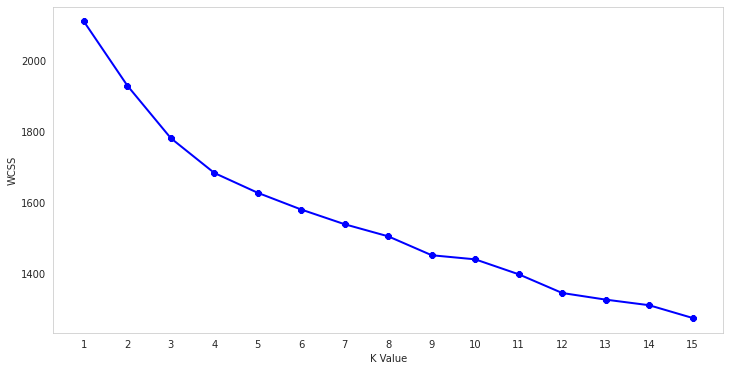

In [118]:
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,16),wcss, linewidth=2, color="blue", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,16,1))
plt.ylabel("WCSS")
plt.show()

In [119]:
kmeans = KMeans()
params={
'n_clusters':[3, 4, 5, 6, 7, 8, 9, 10], 
'init':['k-means++', 'random'],
'algorithm': ['auto', 'full', 'elkan'] 
}

grid = GridSearchCV(kmeans, params, cv=5, n_jobs=-1, verbose=1)

In [120]:
grid.fit(dados_treino)
print('Melhores parâmetros', grid.best_params_)
print('Melhor score', grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.4s


Melhores parâmetros {'algorithm': 'elkan', 'init': 'random', 'n_clusters': 10}
Melhor score -303.21289227958613


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   16.9s finished


In [121]:
# Utiliza melhor modelo selecionado na GridSearch  
kmeans = KMeans(algorithm='elkan', init='random', n_clusters=10)
kmeans.fit(dados_treino)

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [122]:
kmeans_labels = kmeans.labels_

In [123]:
dados_treino['kmeans'] = kmeans_labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [125]:
db(dados_treino, kmeans.labels_)

1.8207949027139463

#### Kmedoids

In [34]:
#https://scikit-learn-extra.readthedocs.io/en/latest/install.html

In [35]:
!pip install scikit-learn-extra

In [126]:
from sklearn_extra.cluster import KMedoids

In [127]:
wcss = []
for k in range(1,16):
    kmedoids = KMedoids(metric="euclidean", n_clusters=k)
    kmedoids.fit(dados_treino)
    wcss.append(kmedoids.inertia_)

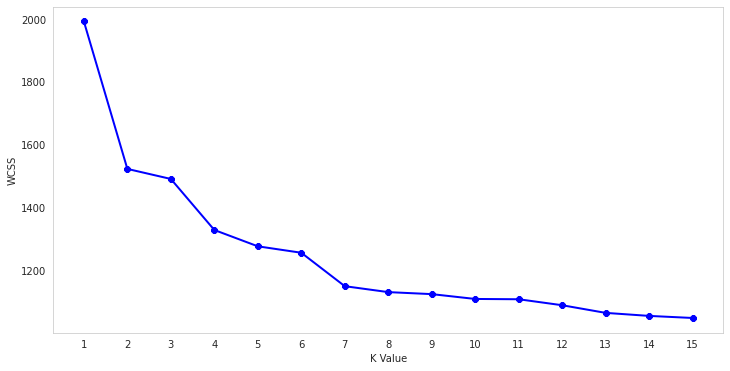

In [128]:
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,16),wcss, linewidth=2, color="blue", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,16,1))
plt.ylabel("WCSS")
plt.show()

In [129]:
n_clusters = [3, 4, 5, 6, 7, 8, 9, 10]
metric = {'euclidean', 'manhattan', 'minkowski'}
init = {'random', 'heuristic', 'k-medoids++'}

best_db = 0
for n in n_clusters:
  for m in metric:
    for i in init:
      kmedoids = KMedoids(metric=m, n_clusters=n, init=i)
      kmedoids.fit(dados_treino)
      current_db = db(dados_treino, kmedoids.labels_)

      if current_db > best_db:
        best_db = current_db
        best_model = kmedoids
print('Melhor modelo:',best_model)

Melhor modelo: KMedoids(init='heuristic', max_iter=300, metric='minkowski', n_clusters=3,
         random_state=None)


In [130]:
# Utiliza melhor modelo selecionado na GridSearch  
kmedoids = KMedoids(init='heuristic', max_iter=300, metric='minkowski', n_clusters=3)
kmedoids.fit(dados_treino)
kmedoids_labels = kmedoids.labels_

In [131]:
dados_treino['kmedoids'] = kmedoids_labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [132]:
db(dados_treino, kmedoids.labels_)

2.87787575753454

#### DBSCAN

In [133]:
from sklearn.cluster import DBSCAN

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [134]:
dbscan = DBSCAN(eps=0.3, min_samples=10, metric='euclidean')
dbscan.fit(dados_treino)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [135]:
dbscan_labels = dbscan.labels_ 

In [136]:
dados_treino['dbscan'] = dbscan_labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [137]:
dados_treino['dbscan'].unique()

array([-1])

#### hierarchical

In [138]:
#https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html
import scipy.cluster.hierarchy as sch

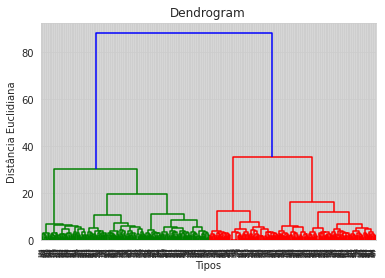

In [139]:
dendrogram = sch.dendrogram(sch.linkage(dados_treino, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Tipos')
plt.ylabel('Distância Euclidiana')
plt.show()

In [140]:
from sklearn.cluster import AgglomerativeClustering

In [141]:
n_clusters = [3, 4, 5, 6, 7, 8, 9, 10]
linkage = {'ward', 'complete', 'average', 'single'}

best_db = 0
for n in n_clusters:
  for l in linkage:
    agg = AgglomerativeClustering(n_clusters=n, linkage=l)
    agg.fit(dados_treino)
    current_db = db(dados_treino, agg.labels_)

    if current_db > best_db:
      best_db = current_db
      best_model = agg
print('Melhor modelo:',best_model)

Melhor modelo: AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=10)


In [142]:
# Utiliza melhor modelo selecionado na GridSearch  
agg = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=10)

In [143]:
agg.fit(dados_treino)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=10)

In [144]:
agg_labels = agg.labels_

In [145]:
dados_treino['agglomerative'] = agg_labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [155]:
db(dados_treino, agg.labels_)

1.2426142961882853

### **PCA**

In [147]:
from sklearn.decomposition import PCA

In [148]:
pca = PCA(n_components=2)

In [149]:
dados_pca = pca.fit_transform(dados_treino)

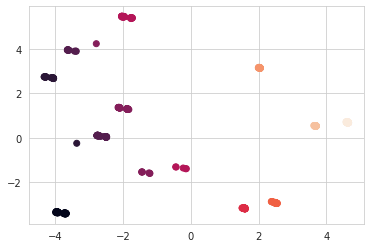

In [150]:
plt.scatter(dados_pca[:, 0],dados_pca[:, 1], c=dados_treino['kmeans'])

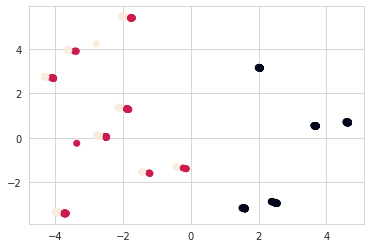

In [151]:
plt.scatter(dados_pca[:, 0],dados_pca[:, 1], c=dados_treino['kmedoids'])

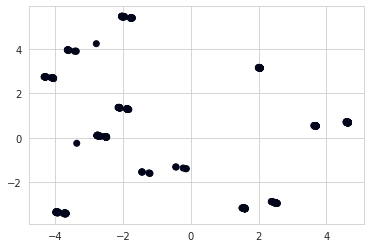

In [152]:
plt.scatter(dados_pca[:, 0],dados_pca[:, 1], c=dados_treino['dbscan'])

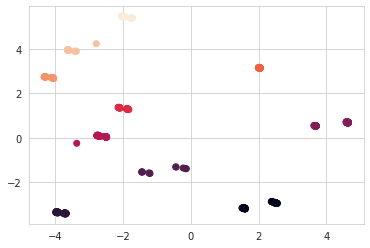

In [153]:
plt.scatter(dados_pca[:, 0],dados_pca[:, 1], c=dados_treino['agglomerative'])


### **Comparação entre os Modelos**

Analisaremos os modelos considerando a medida de similaridade davies_bouldin_score, a qual quanto mais próximo de zero for o valor, melhor o agrupamento.

Nas etapas precedentes, variou-se os parâmetros de cada algoritmo e realizou-se uma GridSearch para escolher o melhor modelo baseado na davies_bouldin_score. O melhor modelo de cada algoritmo será utilizado para as comparações abaixo. 

Ressalta-se que o DBSCAN não mostrou-se apropriado para a base de dados em questão, visto que manteve tudo como um único grupo, sem fazer os agrupamentos. Dessa forma, o mesmo será excluído da análise.

In [156]:
print('Resultados na Base de Treinamento')
print('k-means:',db(dados_treino, kmeans.labels_))
print('kmedoids:',db(dados_treino, kmedoids.labels_))
print('agg:',db(dados_treino, agg.labels_))

Resultados na Base de Treinamento
k-means: 1.674495412711395
kmedoids: 3.830783026957178
agg: 1.2426142961882853


In [159]:
kmeans.fit(dados_teste)
kmedoids.fit(dados_teste)
agg.fit(dados_teste)

print('Resultados na Base de Teste')
print('k-means:',db(dados_teste, kmeans.labels_))
print('kmedoids:',db(dados_teste, kmedoids.labels_))
print('agg:',db(dados_teste, agg.labels_))

Resultados na Base de Teste
k-means: 2.3129890572987546
kmedoids: 3.773456325726386
agg: 2.38820019499839


**Considerações:** na base de treinamento, observou-se que o AgglomerativeClustering apresentou melhor medida de similaridade, já na base de teste, o k-means ficou levemente melhor que o AgglomerativeClustering. Ressalta-se que ambos estão com 10 clusters, ao passo que o kmedoids ficou com 3 clusters. 

Analisando ainda a distribuição dos dados após aplicação do PCA, a qual foi exibida nos scatterplot da seção anterior, percebe-se que os grupos do kmedoids estão pouco coesos, fazendo-nos então descartar este modelo na análise em questão.

Resulta-se que o K-means e AgglomerativeClustering apresentaram resultados bastante semelhantes, sendo as opções mais indicadas para a base em questão dentre todas as avaliadas. O scatterplot do AgglomerativeClustering aparenta um pouco mais de coesão, levando-nos a crer que ele seria a melhor opção e sendo a nossa indicação para essa base.

